Based on 

Convolutional Neural Network (CNN)

https://www.tensorflow.org/tutorials/images/cnn

What does a CNN see?

https://www.kaggle.com/code/aakashnain/what-does-a-cnn-see/notebook

Grad-CAM class activation visualization

https://keras.io/examples/vision/grad_cam/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, Model, load_model
from keras import backend as K

# tf.compat.v1.disable_eager_execution() # daniel

In [2]:
# Set the seed for hash based operations in python
# os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
# tf.set_random_seed(seed) # obsolete
tf.random.set_seed(seed)

# Make the augmentation sequence deterministic
# aug.seed(seed)

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 2s 0us/step


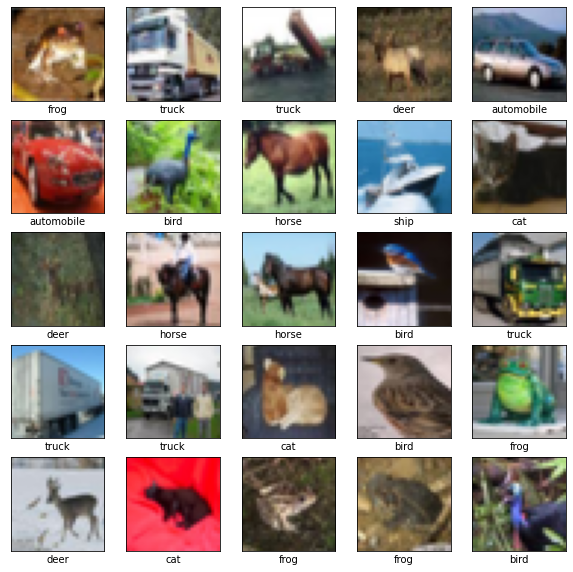

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
# # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# # tf.keras.layers.Conv2D( filters, kernel_size, ...)

# model = models.Sequential()

# model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(32, 32, 3), padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(10))

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.summary()

In [6]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# tf.keras.layers.Conv2D( filters, kernel_size, ...)

model = models.Sequential()

model.add(layers.Conv2D(32, (2, 2), 
                        input_shape=(32, 32, 3), 
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (2, 2), 
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (2, 2), 
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (2, 2), 
                        padding='same',
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [7]:
epochs = 1

In [8]:
%%time

history = model.fit(train_images, 
                    train_labels, 
                    epochs = epochs, 
                    validation_data = (test_images, test_labels))

1563/1563 [==============================] - 24s 15ms/step - loss: 1.4904 - accuracy: 0.4479 - val_loss: 1.1874 - val_accuracy: 0.5705
CPU times: user 4min 37s, sys: 33.9 s, total: 5min 11s
Wall time: 24.4 s


313/313 - 1s - loss: 1.1874 - accuracy: 0.5705 - 1s/epoch - 4ms/step


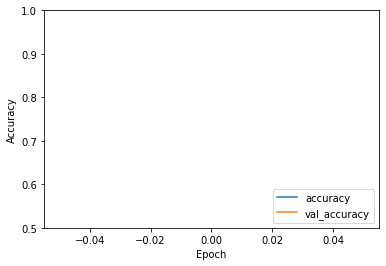

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [10]:
print(test_acc)

0.5705000162124634


In [11]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[0:-3]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# check if we have all the layers we require for visualization 
vis_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         32896 

In [12]:
# vis_model.predict( test_images )

In [13]:
# outputs[-1].name

In [14]:
# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3']


In [15]:
def get_CAM(image, predicted_label, model, layer_name):

    # choose the last conv layer in your model
    conv_layer = model.get_layer( layer_name )

    # https://keras.io/examples/vision/grad_cam/
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [conv_layer.output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(image)
        class_channel = preds[:, tf.argmax(preds[0])]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    conv_layer_output = conv_layer_output[0]
    heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

    # # https://www.kaggle.com/code/aakashnain/what-does-a-cnn-see/notebook
    # # we want the activations for the predicted label
    # predicted_output = model.output[:, predicted_label]
    
    # # get the gradients wrt to the last conv layer
    # grads = K.gradients(predicted_output, conv_layer.output)[0]
    
    # # take mean gradient per feature map
    # grads = K.mean(grads, axis=(0,1,2)) # GAP - Global Average Pooling
    
    # # Define a function that generates the values for the output and gradients
    # evaluation_function = K.function([model.input], [grads, conv_layer.output[0]])
    
    # # get the values
    # grads_values, conv_ouput_values = evaluation_function([image])
    
    # # CAM - Class Activation Map
    # # iterate over each feature map in yout conv output and multiply
    # # the gradient values with the conv output values. This gives an 
    # # indication of "how important a feature is"
    # # for i in range(512): # we have 512 features in our last conv layer
    # for i in range(256): # we have 512 features in our last conv layer
    #     conv_ouput_values[:,:,i] *= grads_values[i]
    
    # # create a heatmap
    # heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # # remove negative values
    # heatmap = np.maximum(heatmap, 0)
    
    # # normalize
    # heatmap /= heatmap.max()
    
    # return heatmap

In [16]:
# img_rows = train_images[16].shape[0]
# img_rows

In [17]:
# img_cols = train_images[16].shape[1]
# img_cols

In [18]:
# img_channels = train_images[16].shape[2]
# img_channels

In [19]:
# test_images[16]

In [20]:
# test_labels[16][0]

In [21]:
# model.predict(test_images)

In [22]:
# pred_labels = model.predict(test_images)
# pred_labels

In [23]:
# pred_labels[0]

In [24]:
# pred_label = np.argmax(pred_labels[0], axis=-1)
# pred_label

In [25]:
# model1 = Model(model.input, model.outputs)
# model1.summary()

In [26]:
# test_images[16].shape

In [27]:
sample_image_processed = np.expand_dims(test_images[16], axis=0)
sample_image_processed.shape

(1, 32, 32, 3)

In [28]:
pred_labels_0 = model.predict(sample_image_processed)
pred_labels_0

1/1 [==============================] - 0s 107ms/step


array([[-2.892999 , -2.5395148,  0.4509526,  2.6353254, -1.2220669,
         2.4353664, -1.1695582,  1.6686536, -1.7499315, -1.9738946]],
      dtype=float32)

In [29]:
pred_label_0 = np.argmax(pred_labels_0, axis=-1)[0]
pred_label_0

3

In [30]:
test_labels[16][0]

5

In [31]:
class_names[pred_label_0]

'cat'

In [32]:
class_names[test_labels[16][0]]

'dog'

In [33]:
# get_CAM(image, predicted_label, model, layer_name)
get_CAM(
    sample_image_processed, 
    pred_label_0, 
    model, 
    layer_names[-1])

array([[1.        , 0.5668935 ],
       [0.7508198 , 0.43993267]], dtype=float32)

In [34]:
# # get the heatmap for class activation map(CAM)
# heatmap = get_CAM(sample_image_processed, 
#                   pred_label_0, 
#                   model, 
#                   layer_names[-1])
# heatmap = cv2.resize(heatmap, (test_images[16].shape[0], test_images[16].shape[1]))
# heatmap = heatmap *255
# heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# super_imposed_image = heatmap * 0.5 + test_images[16]
# super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

In [35]:
# f,ax = plt.subplots(2,2, figsize=(15,8))
# ax[0,0].imshow(test_images[16])
# ax[0,0].set_title(f"True label: {class_names[test_labels[16][0]]} \n Predicted label: {class_names[pred_label_0]}")
# ax[0,0].axis('off')

# ax[0,1].imshow(heatmap)
# ax[0,1].set_title("Class Activation Map")
# ax[0,1].axis('off')

# ax[1,0].imshow(super_imposed_image)
# ax[1,0].set_title("Activation map superimposed")
# ax[1,0].axis('off')
# plt.show()

In [36]:
def visualize_layer(layer):
  
  # get the heatmap for class activation map(CAM)
  heatmap = get_CAM(sample_image_processed, 
                    pred_label_0, 
                    model, 
                    layer)
  heatmap = cv2.resize(
      heatmap, 
      (test_images[16].shape[0], test_images[16].shape[1]))
  heatmap = heatmap *255
  heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  super_imposed_image = heatmap * 0.5 + test_images[16]
  super_imposed_image = np.clip(super_imposed_image, 0, 255).astype(np.uint8)

  # Ploting
  fig, axes = plt.subplots( 1, 3, figsize=( 30, 10 ) )
  axes[0].set_title( f'True label: {class_names[test_labels[16][0]]} \n Predicted label: {class_names[pred_label_0]}' )
  axes[0].axis('off')
  axes[0].imshow( test_images[16] )
  axes[1].set_title( f'Class Activation Map - Layer: {layer}' )
  axes[1].axis('off')
  axes[1].imshow( heatmap )
  axes[2].set_title( f'Activation Map Superimposed - Layer: {layer}' )
  axes[2].axis('off')
  axes[2].imshow( super_imposed_image )
  plt.show()

  # # Plot just CAM of the layer
  # plt.figure( figsize=(2, 2) )
  # plt.title( f'Class Activation Map - Layer: {layer}' )
  # plt.imshow( heatmap )
  # plt.show()

  print()

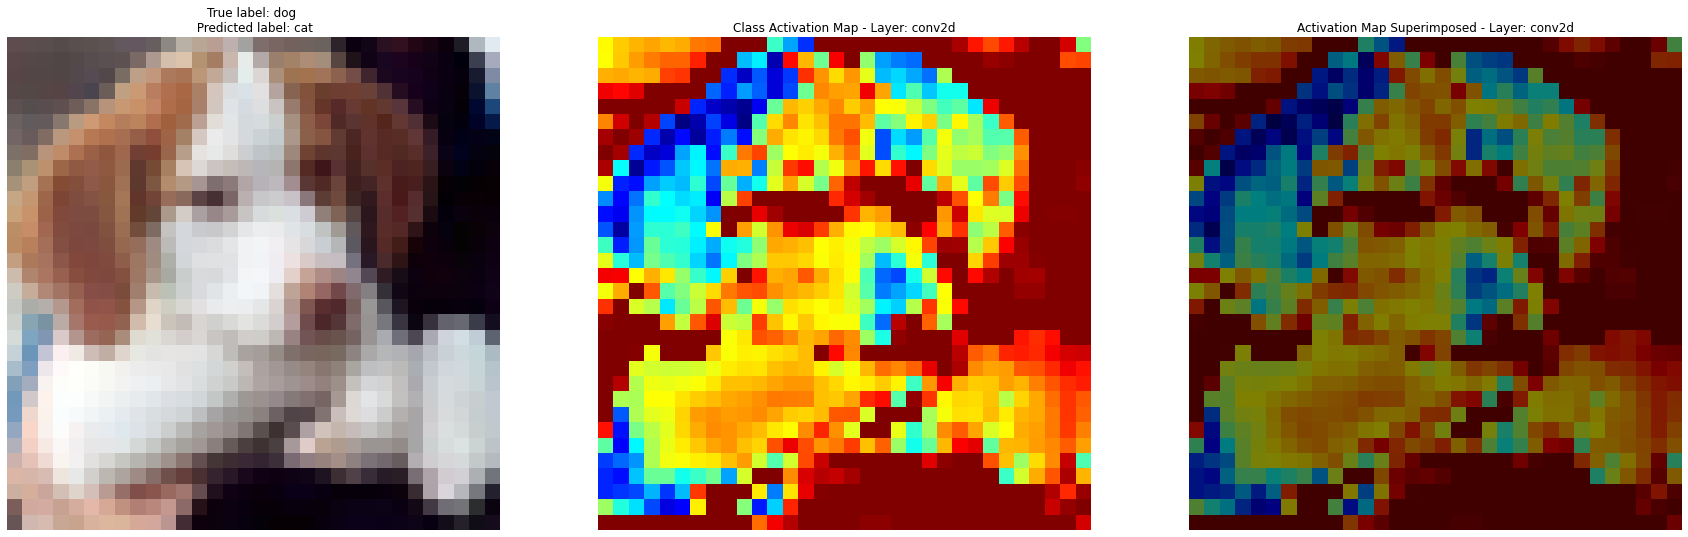

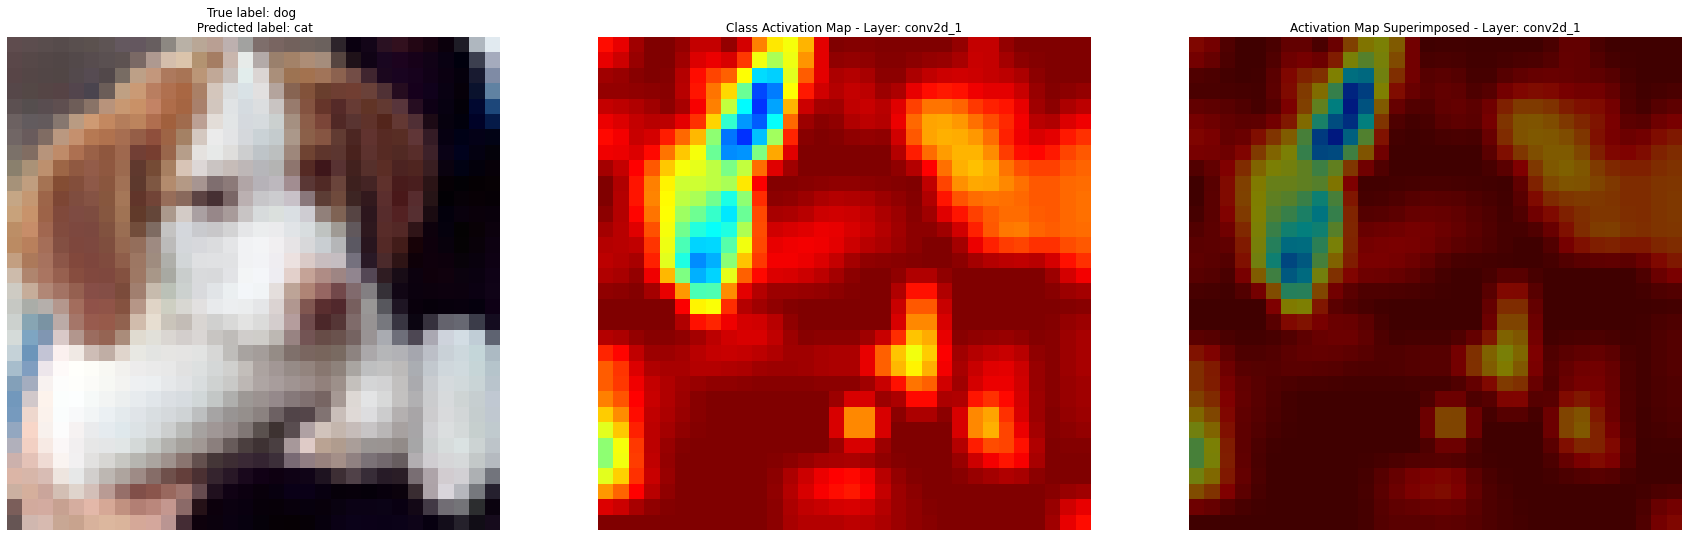

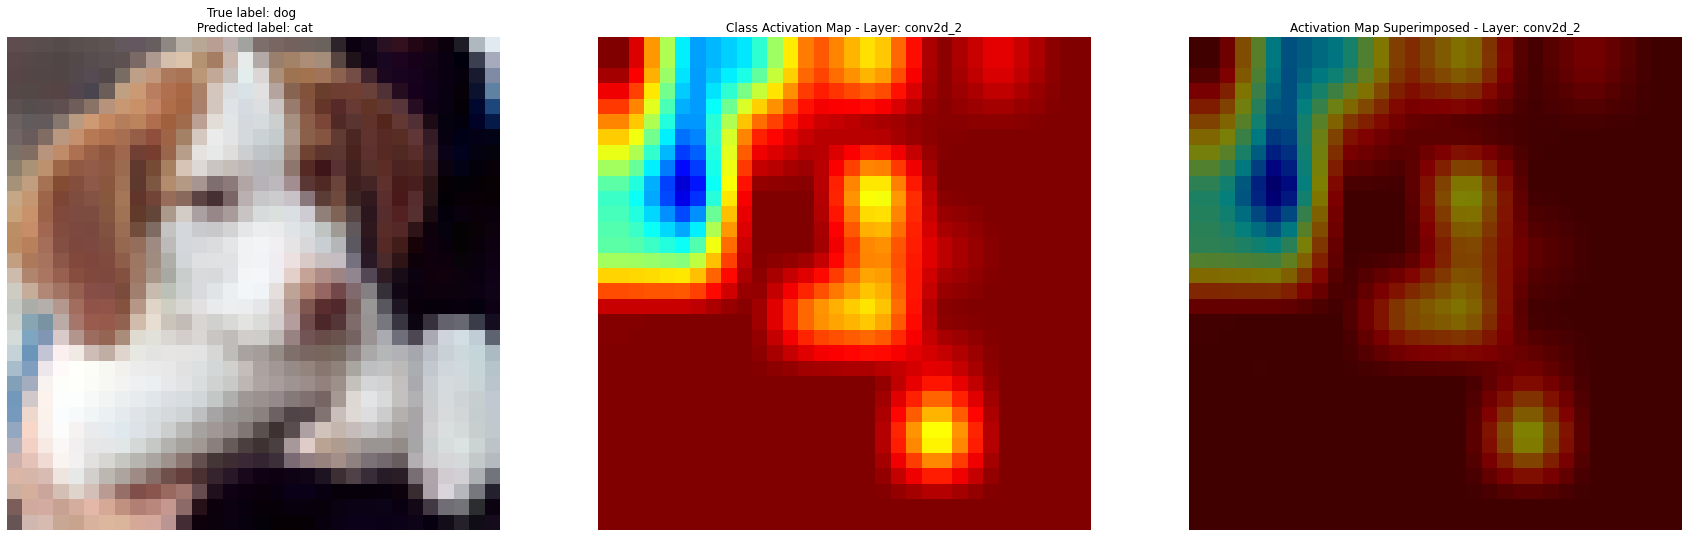

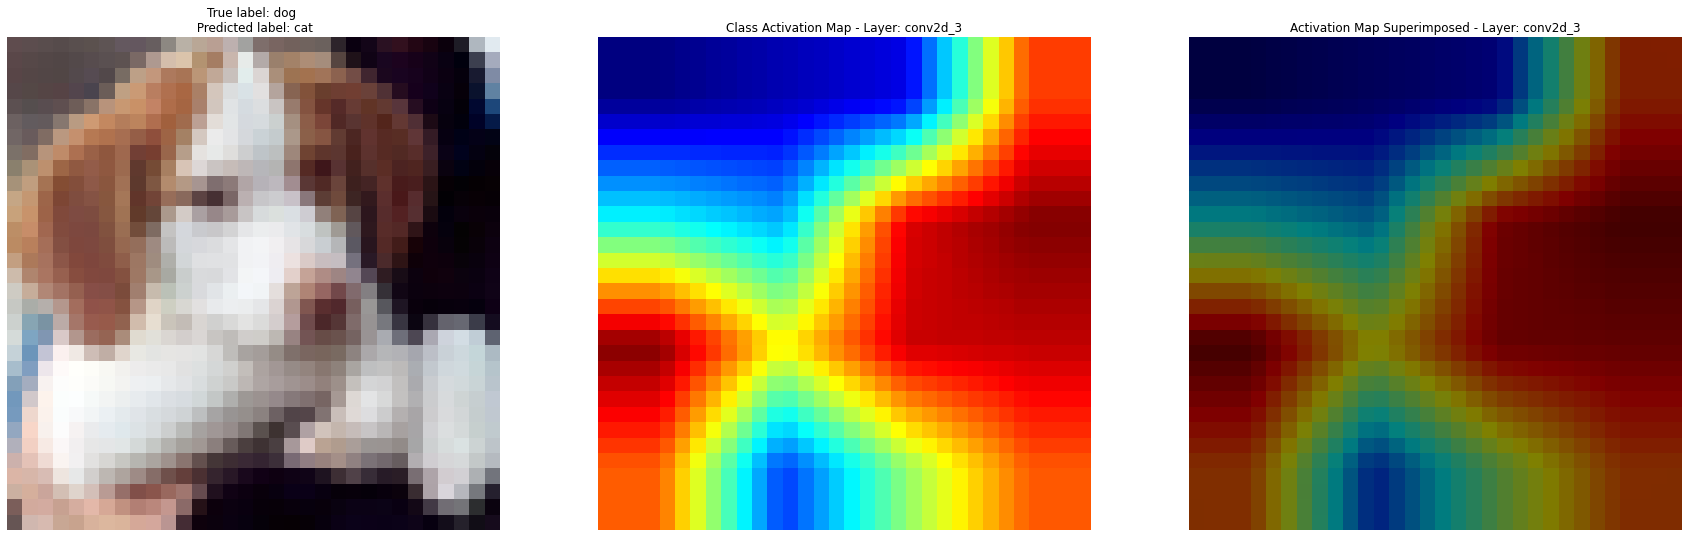

In [37]:
# layer_names_reversed = layer_names[::-1] #reversing using list slicing
# for layer in layer_names_reversed:
for layer in layer_names:

  if 'pooling' not in layer:
    visualize_layer(layer)

In [38]:
# for index, test_img in enumerate( test_images ):

#   if index > 20:
#     break
  
#   # Plot just CAM of the layer
#   plt.figure( figsize=(1, 1) )
#   plt.title( f'index: {index}' )
#   plt.imshow( test_img )
#   plt.show()